## Build a graph with nodes as objects and edges as deltas between them 

The node atributes are $p_T, \phi, \eta, id$ where $id$ is 0 for leptons, -1 for met and the b-quantile for jets 

### Need to pick out the variables we'll use for building the edges
This will be a function of the angular distance between objets and their pT:
$$\delta_{ij} = |\phi_i-\phi_j|,  |\eta_i-\eta_j|,  |p_{T_i}-p_{T_j}|$$

Think this is the fastest way to do it:

Populate matrices containing the $p_T, \phi, \eta$ of the source and dests then subtract in one go 

In [1]:
import numpy as np
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class wh_dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
    @property
    def raw_file_names(self):
        return["X_train.npy", "Y_train.npy", "W_train.npy"]
    @property
    def processed_file_names(self):
        return ["data.pt"]
    @property
    def processed_dir(self):
        return "data/processed/"
    @property
    def processed_paths(self):
        return [self.processed_dir+fname for fname in self.processed_file_names]
    
    #Helper functions for process
    def get_variables(self):
        import NN_driver as driver #The variable names are stored in the driver config
        variables = driver.variables
        variables  = [v for v in variables if "j3" not in v]
        variables  = [v for v in variables if "j2" not in v]
        return variables
    
    def get_edge_indices(self, x):
        # Getting all the info for the edges NB: this only needs to be done once->outside loop
        ## Edge indices: 2 lists, first is source node indices and second is destination node indices
        ## x has shape, (instances, nodes, attributes)
        source = np.arange(0,x.shape[1]).repeat(x.shape[1]-1)
        d = np.arange(0,x.shape[1])
        dest = np.asarray([np.delete(d,i) for i in d]).flatten()
        return np.asarray([source,dest])
    
    def populate_nodes(self, x):
        print("Populating the nodes with attributes")
        # Getting all the info for the individual nodes
        ## Last index is the id of the node-jets have their b-quantile, leptons are 0, met is -1
        ### met
        met_arr = x[:,self.met_vars]
        met_eta_quant = np.full((x.shape[0],2), [0, -1])
        met_arr = np.concatenate((met_arr, met_eta_quant), axis=1) # Appending the eta and quant values to met
        ### lepton
        lept_arr = x[:,self.l1_vars]
        lep_quant = np.zeros((x.shape[0],1))
        lept_arr = np.concatenate((lept_arr, lep_quant), axis=1) # Appending the eta and quant values to met
        ### Jets
        b1_arr = x[:,self.b1_vars]
        b2_arr = x[:,self.b2_vars]
        j1_arr = x[:,self.j1_vars]
        ### Put them all together
        return np.stack((met_arr, lept_arr, b1_arr, b2_arr, j1_arr),axis=1)
    
    def populate_edges(self, x, edge_indices, metric="3-space"):
        # Create 2 arrays (source, dest) of attributes using the edge indices and subtract them from each other to get the edge attributes
        print("Populating the edges with attributes")
        metrics = ["3-space", "angular", "phi"]
        if metric not in metric:
            raise AttributeError("%s is not an available metric, use: '3-space', 'angular', 'phi'")
        if metric == "3-space":
            metric_vars = [0,1,2]
        elif metric == "angular":
            metric_vars = [1,2]
        elif metric == "phi":
            metric_vars = [1]
        sources  = x[:,edge_indices[0],:]# Map a matrix of values by the source indices
        sources  = sources[:,:,metric_vars]
        dests    = x[:,edge_indices[1],:]# Map a matrix of values by the dest indices
        dests  = dests[:,:,metric_vars] # Angular space
        deltas = sources - dests
        return deltas
    
    def process(self):
        # Sort out the variables we need based on the driver config
        variables = self.get_variables()
        self.met_vars = [variables.index('ETMiss'),variables.index('ETMissPhi')]
        self.l1_vars = [variables.index('pTl1'),variables.index('phil1'),variables.index('etal1')]
        self.b1_vars = [variables.index('pTb1'),variables.index('phib1'),variables.index('etab1'),variables.index('b1_quantile')]
        self.b2_vars = [variables.index('pTb2'),variables.index('phib2'),variables.index('etab2'),variables.index('b2_quantile')]
        self.j1_vars = [variables.index('pTj1'),variables.index('phij1'),variables.index('etaj1'),variables.index('j1_quantile')]
        print("Loading input data")
        x = np.load(self.root+"/"+self.raw_file_names[0])
        y = np.load(self.root+"/"+self.raw_file_names[1])
        
        # Get the variables associated to the objects in the event
        #node_indices = [1,2,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
        x = x[:,:] # These are the object-related variables
        node_attrs = self.populate_nodes(x) # Convert the objects to node data
        # Get the edges and populate them with edge data
        print(node_attrs.shape)
        edge_indices = self.get_edge_indices(node_attrs)
        edge_attrs = self.populate_edges(node_attrs, edge_indices)
        print(edge_attrs.shape)
        
        node_attrs = torch.tensor(node_attrs, dtype=torch.float, device=device)
        edge_indices = torch.tensor(edge_indices, dtype=torch.long, device=device) #Is the same for every graph for now, only calculate once
        edge_attrs = torch.tensor(edge_attrs, dtype=torch.float, device=device) 
        y = torch.tensor(y,dtype=torch.long, device=device)
        #y = torch.nn.functional.one_hot(y)
        
        data_list = [Data(x=x, edge_index=edge_indices, edge_attr=edge_attr, y=y) for x,edge_attr,y in zip(node_attrs, edge_attrs, y)]
        
        
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        data, slices = self.collate(data_list)
        torch.save((data,slices), self.processed_dir+"/"+self.processed_file_names[0])

In [2]:
device

device(type='cpu')

In [3]:
data = wh_dataset("data/")

Processing...


Loading input data
Populating the nodes with attributes
(3167060, 5, 4)
Populating the edges with attributes
(3167060, 20, 3)


Done!


## Do some visualisation

In [4]:
from torch_geometric.utils.convert import to_networkx
import networkx as nx

In [5]:
datagraph = to_networkx(data[0])
labeldict = {}
labeldict[0] = "MET"
labeldict[1] = "lep"
labeldict[2] = "b1"
labeldict[3] = "b2"
labeldict[4] = "j1"

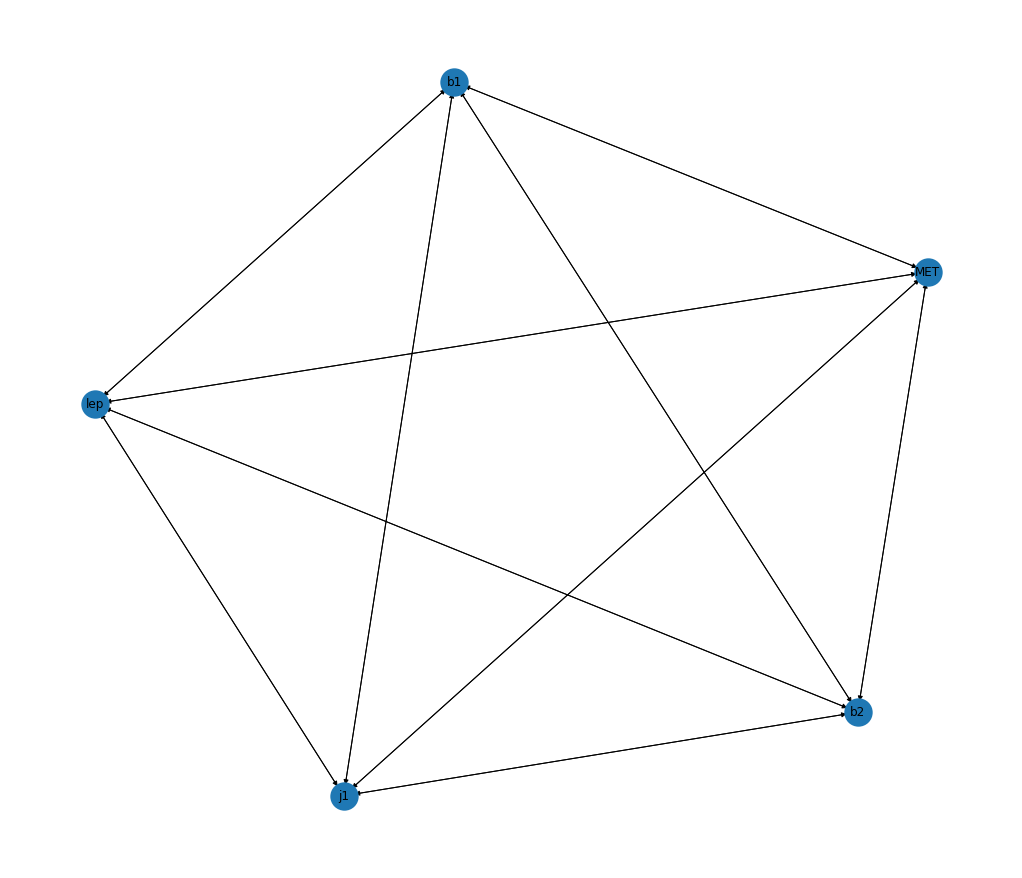

In [6]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(14,12)) 
nx.draw(datagraph, cmap=plt.get_cmap('Set1'),labels=labeldict, node_size=500,linewidths=6, with_labels=True)
plt.show()

In [7]:
data.num_classes

5

## Setup some batching and start learning

In [8]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, data=data):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, data.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64, data=data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GCN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
)


## Training

In [12]:
from torch_geometric.loader import DataLoader
loader = DataLoader(data, batch_size=1000, shuffle=True)

In [ ]:
from tqdm import tqdm
model.train()
for epoch in range(1,3):
    for batch in tqdm(loader):
        out=model(batch.x,batch.edge_index,batch.batch)
        pred = out.argmax(dim=1) 
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    correct = 0
    for batch in tqdm(loader):
        model.eval()
        out=model(batch.x,batch.edge_index,batch.batch)
        pred = out.argmax(dim=1) 
        correct += int((pred == data.y).sum())
    acc = correct/len(loader.dataset)
    print("Epoch: %i, Loss: %f, Acc:%f"%(epoch,loss, acc))

 12%|████████████████████████████████                                                                                                                                                                                                                                           | 381/3168 [02:19<17:24,  2.67it/s]